# NeighborMom() vs AnyMom()

In [18]:
function neighborMom(network::NetworkParameters, kID::Int64)
    fitWeights = StatsBase.weights([network.popFitness[kID%100+1], network.popFitness[(kID+98)%100+1]]) #index plus/minus one, loops around 100
    momIndex = (kID + sample([1, -1], fitWeights) + 99)%100 + 1 #have to use (idx +99)%100 + 1 to loop from 100 to 1 properly
    momIndex
end

function anyMom(network::NetworkParameters, kID::Int64)
    network.popFitness[kID] = 0
    fitWeights = StatsBase.weights(network.popFitness)
    momIndex = sample(1:network.popSize, fitWeights)
    resolveLocs(network, kID, momIndex) #updates locations, ensures each individual has a unique location by inserting the child adjacent to the parent and pushing others away 
    momIndex
end

UndefVarError: UndefVarError: NetworkParameters not defined

Both NeighborMom() and AnyMom() serve as different methods replacing FindMom() based on our method of selecting parents. NeighborMom() only compares fitnesses of neighboring individuals, while AnyMom() looks at fitnesses of all individuals in the population. Locations do not need to be separately updated for NeighborMom(), as each individual is automatically adjacent to a parent. 

**Old heatmap for Iterating by Ben/CL**

In [19]:
using JLD2
using StatsBase
using Plots
#backend(:plotly)
using DataFrames
using CSV

In [20]:
function dataRead(data, range, index::Int)
    df = CSV.read(data, DataFrame, delim=",")
    df = df[!, [2, 3, 5, 6, 8, 12, 13, 14, 15, 16, 4, 11, 10, 7, 9, 1]] #used for soring by ben/cl, including graphCalcs
    #df = df[!, [6, 9, 2, 3, 7, 8, 10, 4, 5, 1]] #used for when sorting by pn/r
    #sort!(df, [:pn, :pr]) #used for when sorting by pn/r
    sort!(df, [:ben, :cl])
    dfData = Matrix{Float64}(df)
    dataArr = zeros(range, range, 1) #transforms [range^2 * 10] arr to [range, range, 1] arr
    for(i) in 1:range
        for(j) in 1:range
            dataArr[i, j, 1] = dfData[range*(i-1)+j, index]
        end
    end
    #print(dataArr)
    dataArr
end

function hmap(data::String, range::Int, index::Int, titles::String, cLow::Float64, chI::Float64) 
    #indexes : 1 yidx   2 xidx   3 coopFreq   4 degree   5 fitness  6 pnc_end   7 pnd_end   8 prc_end  9 prd_end  10 shortestPath 11 connComponents 12 meanCCSize 13 largestCC 14 distance  15 inclusion  16 assortment 
    dataArr = dataRead(data, range, index)
    x_axis = String[]
    y_axis = String[]
    for(i) in 1:range #PNC/PND times 10
        push!(x_axis, (string(round((0.4*i/range); digits = 4))))
        push!(y_axis, (string(round((10*i/range); digits = 3))))
    end
    p = heatmap(x_axis, y_axis,  dataArr[:, :, 1]; title = titles, xlabel="CL",ylabel="BEN", clim=(cLow,chI))
end

hmap (generic function with 1 method)

# High Strength of Selection, AnyMom(), no Distance-based inheritance
The following two runs were created before distance inheritance was implemented, so do not have the mean connection distance and have to use an older hmap() function.

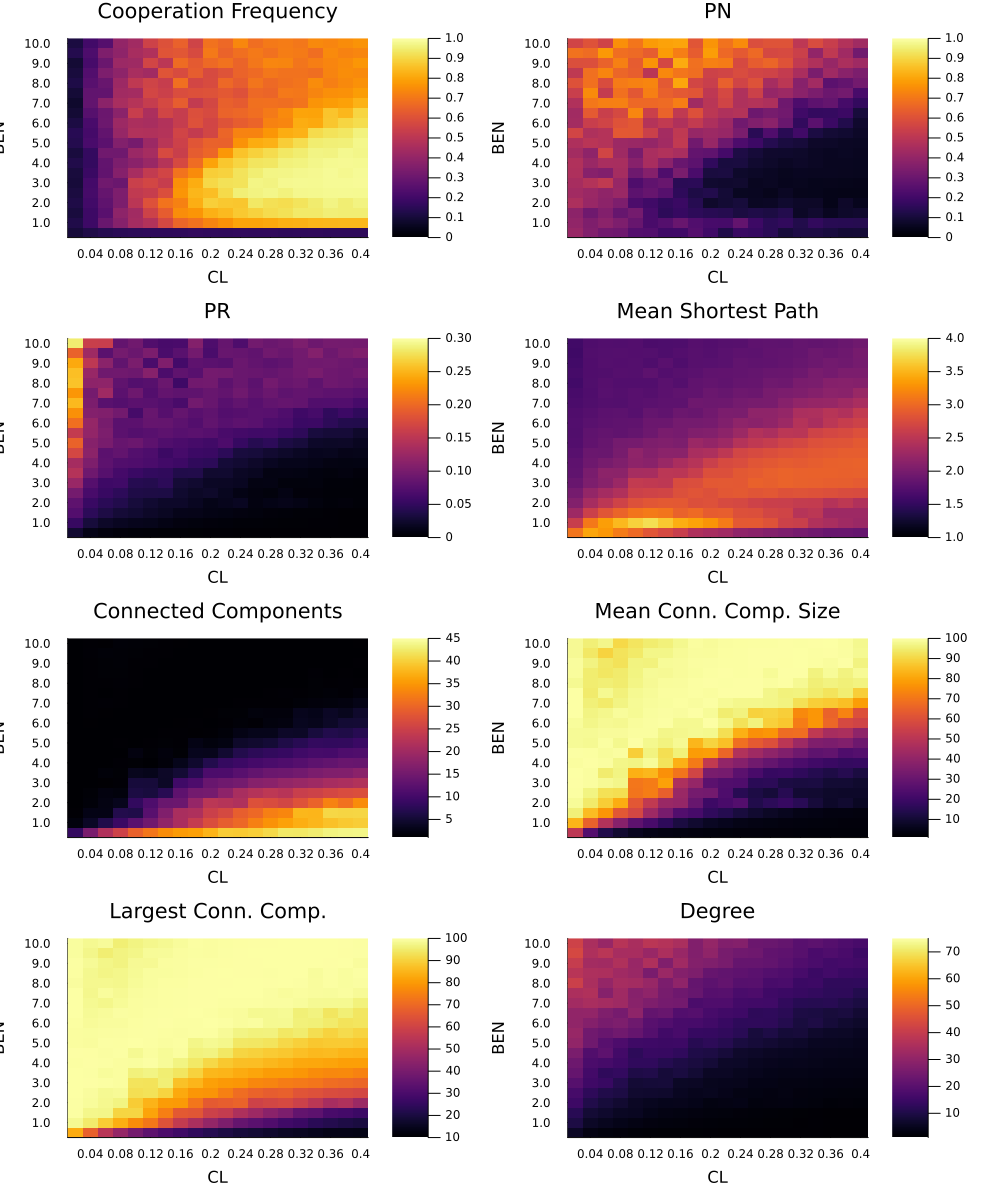

In [21]:
file = "sup_6_no_pnd_new_graphs.csv"
fig1hmaps = [hmap(file, 20, 3, "Cooperation Frequency", 0.0, 1.0), 
hmap(file, 20, 6, "PN", 0.0, 1.0), 
hmap(file, 20, 8, "PR", 0.0, 0.3),
hmap(file, 20, 10, "Mean Shortest Path", 1.0, 4.0), 
hmap(file, 20, 11, "Connected Components", 1.0, 45.0), 
hmap(file, 20, 12, "Mean Conn. Comp. Size", 1.0, 100.0), 
hmap(file, 20, 13, "Largest Conn. Comp.", 10.0, 100.0),
hmap(file, 20, 4, "Degree", 1.0, 75.0)] 

plot(fig1hmaps..., colorbar = true, grid=false, layout = (4,2), size = (1000, 1200)) 

**Figure 1** High strength of selection with the mother selected from any individual, pnd and prd not evolving separately. The results above were created with: C=0.5, D=0.0, gen=100000, pn=0.5, distInherit=false, pnd=false, pr=0.0001, prd=false, muP=0.01, delta=0.5, sigmapn=0.01, sigmapr=0.01, reps=10. Initial cooperation frequency was 0.5.

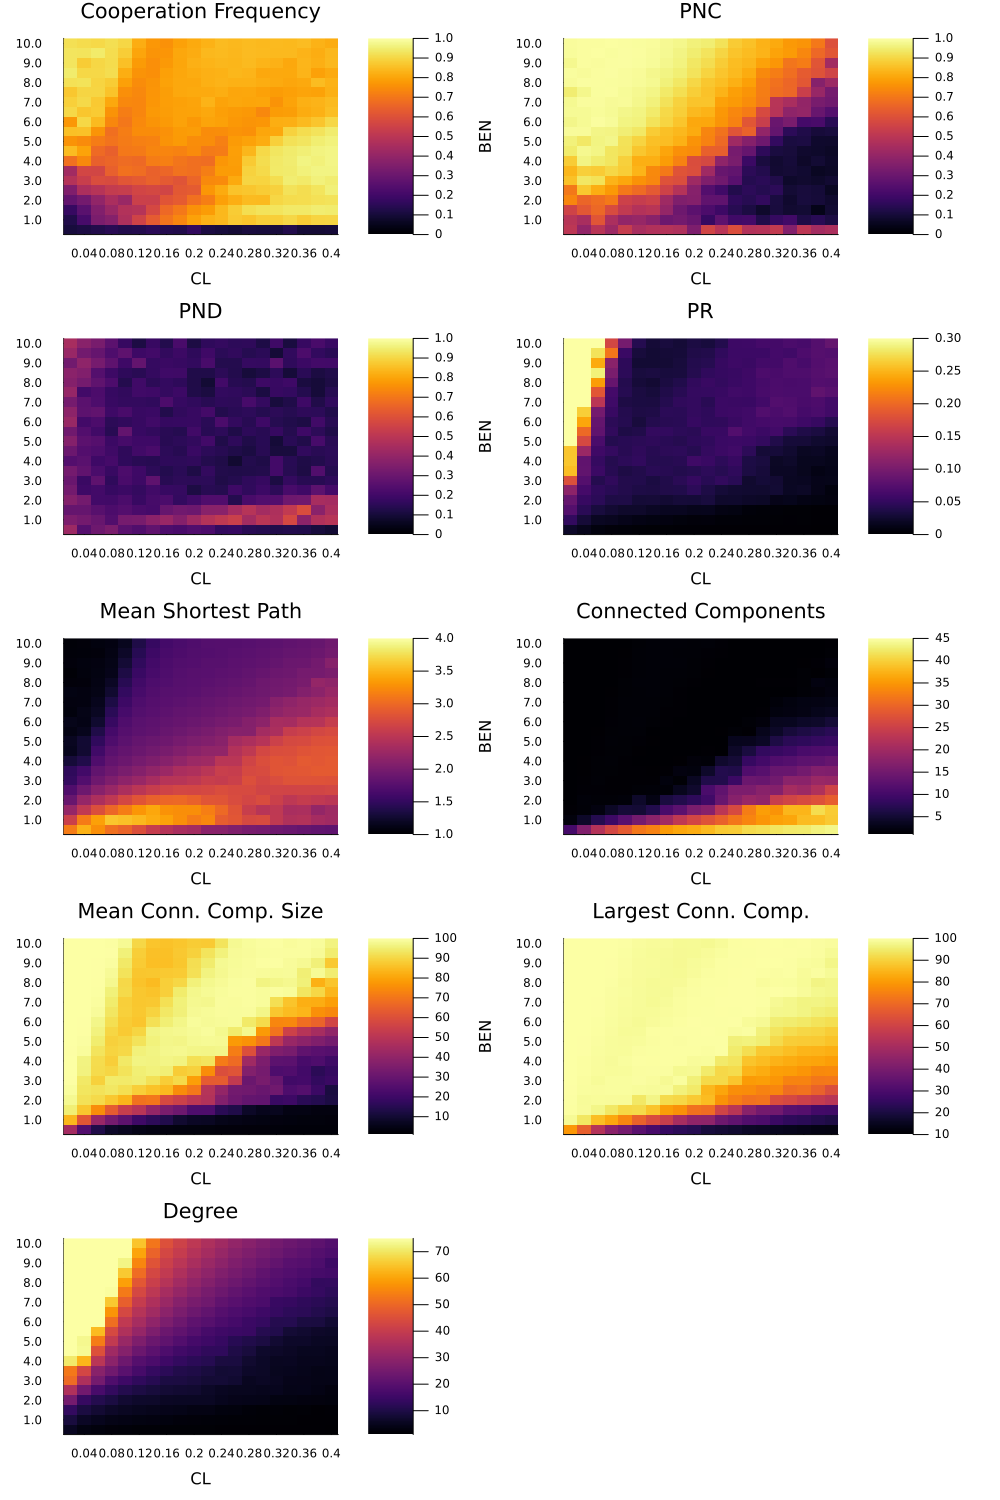

In [22]:
file = "sup_6_pnd_new_graphs.csv"
fig1hmaps = [hmap(file, 20, 3, "Cooperation Frequency", 0.0, 1.0), 
hmap(file, 20, 6, "PNC", 0.0, 1.0), 
hmap(file, 20, 7, "PND", 0.0, 1.0),
hmap(file, 20, 8, "PR", 0.0, 0.3),
hmap(file, 20, 10, "Mean Shortest Path", 1.0, 4.0), 
hmap(file, 20, 11, "Connected Components", 1.0, 45.0), 
hmap(file, 20, 12, "Mean Conn. Comp. Size", 1.0, 100.0), 
hmap(file, 20, 13, "Largest Conn. Comp.", 10.0, 100.0),
hmap(file, 20, 4, "Degree", 1.0, 75.0)] 

plot(fig1hmaps..., colorbar = true, grid=false, layout = (5,2), size = (1000, 1500)) 

**Figure 2** High strength of selection with the mother selected from any individual, pnd but not prd evolving separately. The results above were created with: C=0.5, D=0.0, gen=100000, pn=0.5, distInherit=false, pnd=true, pr=0.0001, prd=false, muP=0.01, delta=0.5, sigmapn=0.01, sigmapr=0.01, reps=10. Initial cooperation frequency was 0.5.

**New Heatmap Function**

In [23]:
function dataRead(data, range, index::Int)
    df = CSV.read(data, DataFrame, delim=",")
    df = df[!, [2, 3, 5, 6, 8, 13, 14, 15, 16, 17, 4, 11, 10, 12, 7, 9, 1]] #used for soring by ben/cl, including graphCalcs
    #df = df[!, [6, 9, 2, 3, 7, 8, 10, 4, 5, 1]] #used for when sorting by pn/r
    #sort!(df, [:pn, :pr]) #used for when sorting by pn/r
    sort!(df, [:ben, :cl])
    dfData = Matrix{Float64}(df)
    dataArr = zeros(range, range, 1) #transforms [range^2 * 10] arr to [range, range, 1] arr
    for(i) in 1:range
        for(j) in 1:range
            dataArr[i, j, 1] = dfData[range*(i-1)+j, index]
        end
    end
    #print(dataArr)
    dataArr
end

function hmap(data::String, range::Int, index::Int, titles::String, cLow::Float64, chI::Float64) 
    #indexes : 1 yidx   2 xidx   3 coopFreq   4 degree   5 fitness  6 pnc_end   7 pnd_end   8 prc_end  9 prd_end  10 shortestPath 11 connComponents 12 meanCCSize 13 largestCC 14 mean connection distance 15 distance  16 inclusion  17 assortment 
    dataArr = dataRead(data, range, index)
    x_axis = String[]
    y_axis = String[]
    for(i) in 1:range #PNC/PND times 10
        push!(x_axis, (string(round((0.4*i/range); digits = 4))))
        push!(y_axis, (string(round((10*i/range); digits = 3))))
    end
    p = heatmap(x_axis, y_axis,  dataArr[:, :, 1]; title = titles, xlabel="CL",ylabel="BEN", clim=(cLow,chI))
    p
end

#redefined hmap() in between runs


hmap (generic function with 1 method)

# High Strength of Selection, NeighborMom(), no Distance-based inheritance

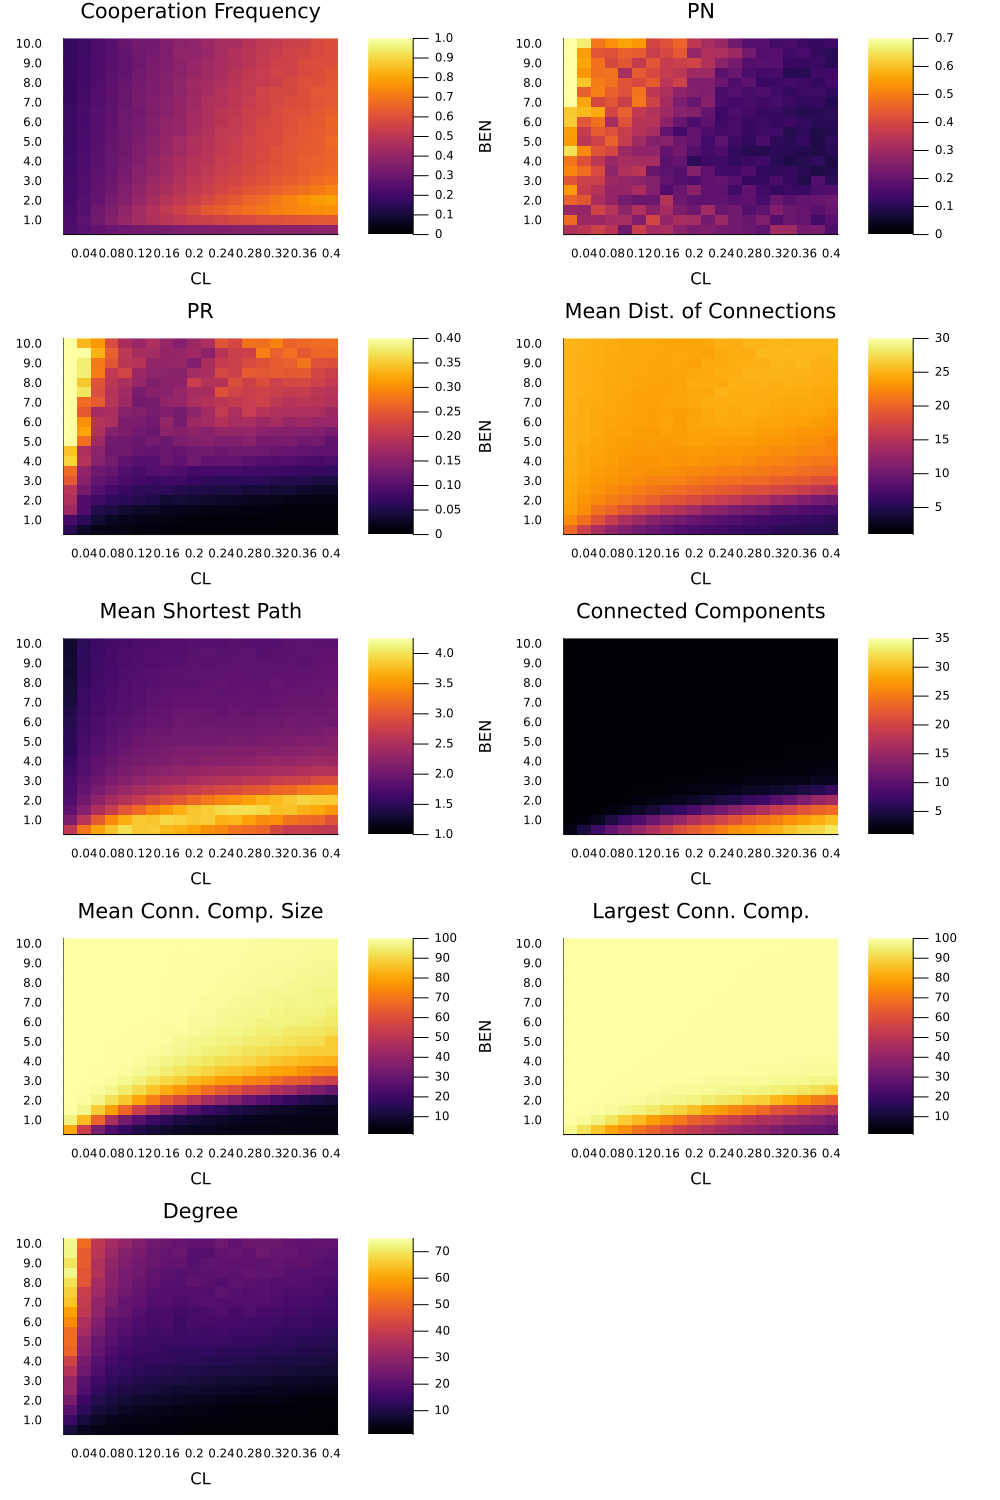

In [24]:
file = "neighbor_mom_no_pnd_fixed.csv"
fig1hmaps = [hmap(file, 20, 3, "Cooperation Frequency", 0.0, 1.0), 
hmap(file, 20, 6, "PN", 0.0, 0.7), 
hmap(file, 20, 8, "PR", 0.0, 0.40),
hmap(file, 20, 14, "Mean Dist. of Connections", 1.0, 30.0),
hmap(file, 20, 10, "Mean Shortest Path", 1.0, 4.25), 
hmap(file, 20, 11, "Connected Components", 1.0, 35.0), 
hmap(file, 20, 12, "Mean Conn. Comp. Size", 1.0, 100.0), 
hmap(file, 20, 13, "Largest Conn. Comp.", 1.0, 100.0),
hmap(file, 20, 4, "Degree", 1.0, 75.0)
]
#,

plot(fig1hmaps..., colorbar = true, grid=false, layout = (5,2), size = (1000, 1500)) 

**Figure 3** High strength of selection with the mother selected from dead individuals' neighbors, pnd and prd not evolving separately. The results above were created with: C=0.5, D=0.0, gen=100000, distInherit=false, distFactor=1.0, pn=0.5, findMom=neighborMom, pnd=false, pr=0.0001, prd=false, muP=0.01, delta=0.5, sigmapn=0.01, sigmapr=0.01, reps=10). Initial cooperation frequency was 0.5 .

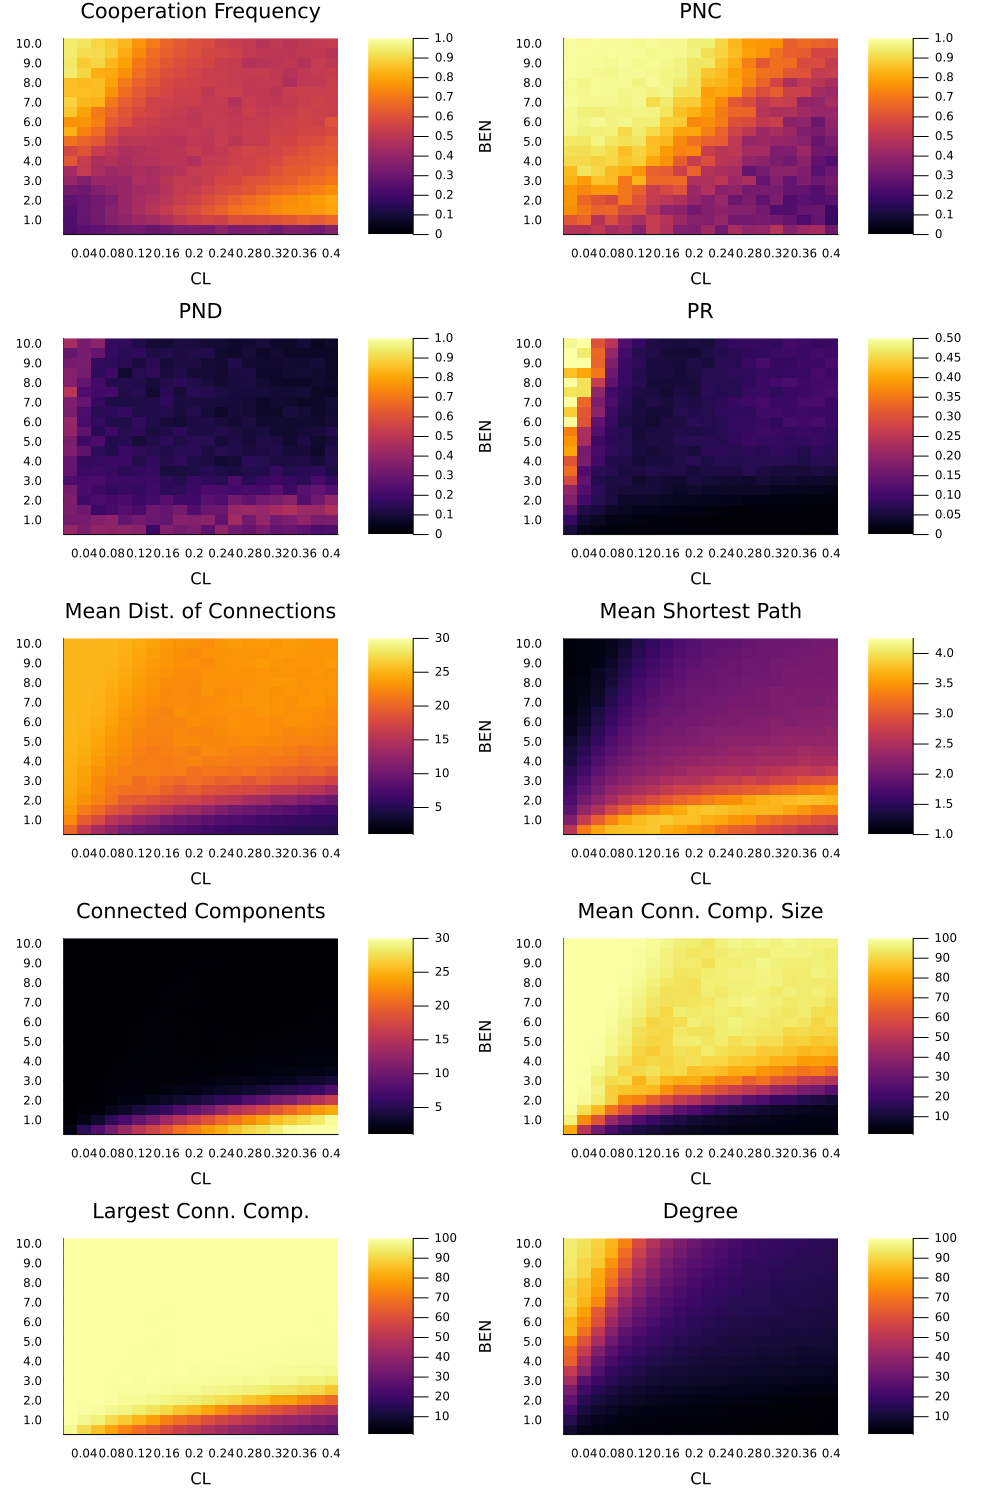

In [25]:
file = "neighbor_mom_pnd.csv"
fig1hmaps = [hmap(file, 20, 3, "Cooperation Frequency", 0.0, 1.0), 
hmap(file, 20, 6, "PNC", 0.0, 1.0), 
hmap(file, 20, 7, "PND", 0.0, 1.0),
hmap(file, 20, 8, "PR", 0.0, 0.50),
hmap(file, 20, 14, "Mean Dist. of Connections", 1.0, 30.0),
hmap(file, 20, 10, "Mean Shortest Path", 1.0, 4.25), 
hmap(file, 20, 11, "Connected Components", 1.0, 30.0), 
hmap(file, 20, 12, "Mean Conn. Comp. Size", 1.0, 100.0), 
hmap(file, 20, 13, "Largest Conn. Comp.", 1.0, 100.0),
hmap(file, 20, 4, "Degree", 1.0, 100.0)
]
#,

plot(fig1hmaps..., colorbar = true, grid=false, layout = (5,2), size = (1000, 1500)) 

**Figure 4** High strength of selection with the mother selected from dead individuals' neighbors, pnd but not prd evolving separately. The results above were created with: C=0.5, D=0.0, gen=100000, distInherit=false, distFactor=1.0, pn=0.5, findMom=neighborMom, pnd=true, pr=0.0001, prd=false, muP=0.01, delta=0.5, sigmapn=0.01, sigmapr=0.01, reps=10). Initial cooperation frequency was 0.5 . File name: "neighbor_mom_pnd.csv"

# High Strength of Selection, NeighborMom(), Distance-based inheritance

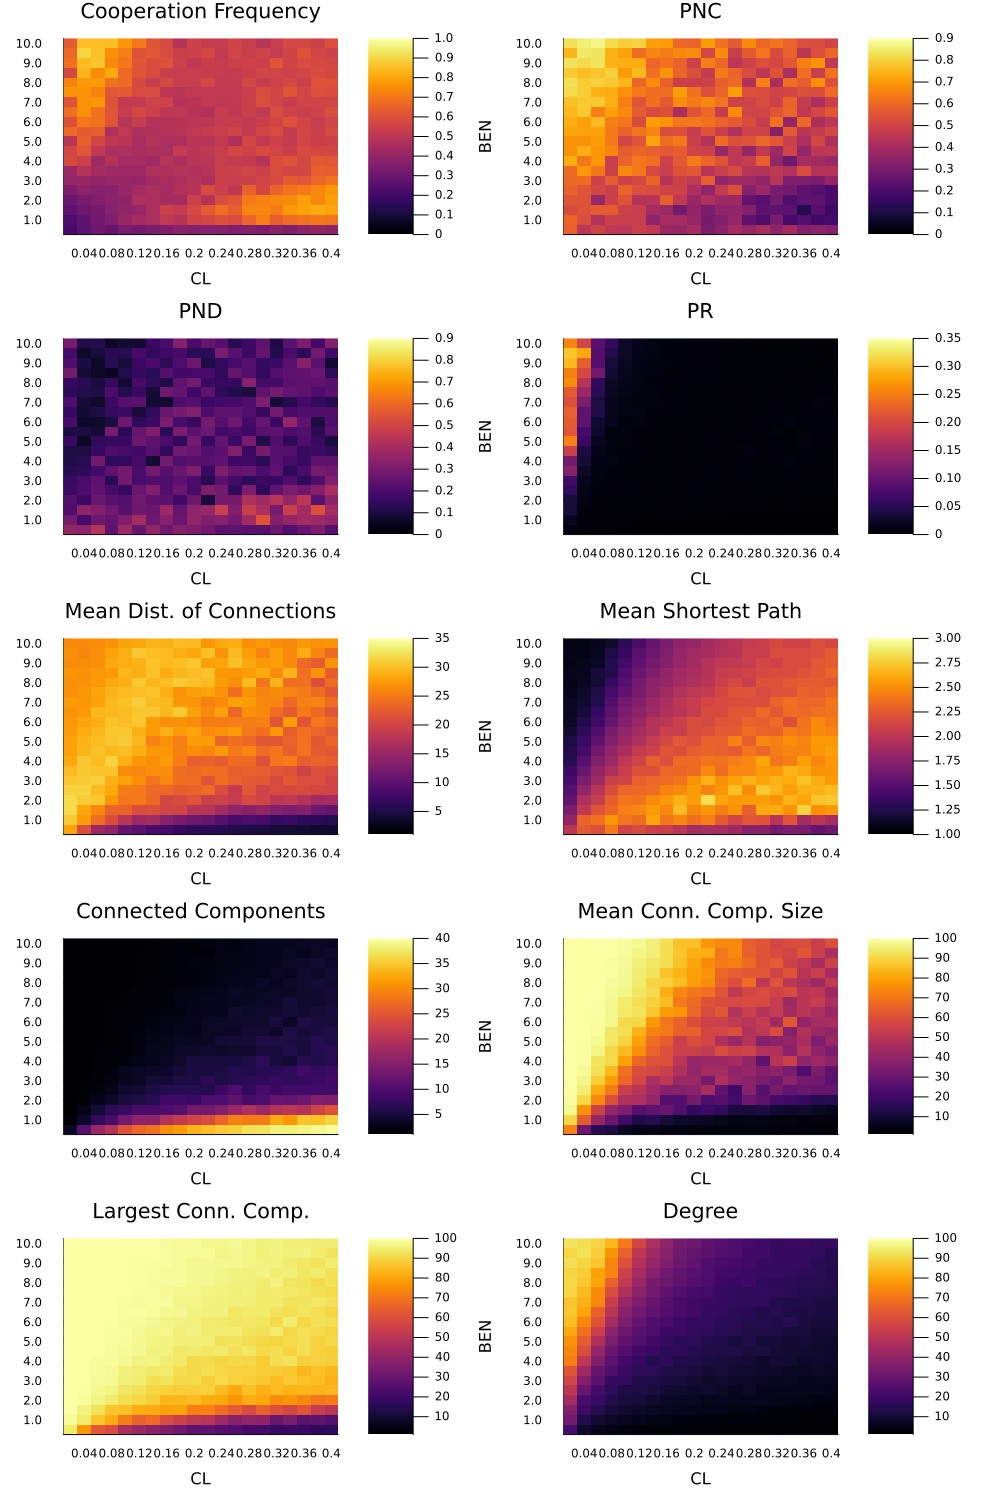

In [31]:
file = "neighbor_mom_pnd_0.95_dist.csv"
fig1hmaps = [hmap(file, 20, 3, "Cooperation Frequency", 0.0, 1.0), 
hmap(file, 20, 6, "PNC", 0.0, 0.9), 
hmap(file, 20, 7, "PND", 0.0, 0.9),
hmap(file, 20, 8, "PR", 0.0, 0.35),
hmap(file, 20, 14, "Mean Dist. of Connections", 1.0, 35.0),
hmap(file, 20, 10, "Mean Shortest Path", 1.0, 3.0), 
hmap(file, 20, 11, "Connected Components", 1.0, 40.0), 
hmap(file, 20, 12, "Mean Conn. Comp. Size", 1.0, 100.0), 
hmap(file, 20, 13, "Largest Conn. Comp.", 1.0, 100.0),
hmap(file, 20, 4, "Degree", 1.0, 100.0)
]
#,

plot(fig1hmaps..., colorbar = true, grid=false, layout = (5,2), size = (1000, 1500)) 

**Figure 6** High strength of selection with the mother selected from dead individuals' neighbors, pnd but not prd evolving separately. The results above were created with: C=0.5, D=0.0, gen=100000, distInherit=false, distFactor=1.0, pn=0.5, findMom=neighborMom, pnd=true, pr=0.0001, prd=false, muP=0.01, delta=0.5, sigmapn=0.01, sigmapr=0.01, reps=10). Initial cooperation frequency was 0.5 . File name: "neighbor_mom_pnd.csv"